### 데이터 분석 프로젝트 절차
1. 분석 기획 (주가 예측 - 어떤 주가를 예측할 것인가?)
2. 데이터 수집 (크롤링, 라이브러리, 다운로드, API)
3. 데이터 탐색 (EDA) 및 가공
4. 모델링 (어떤 모델을 사용할 것인가?)
5. 학습
6. 평가 (테스트)

In [1]:
%pip install -U finance-datareader

In [6]:
import FinanceDataReader as fdr

df_krx = fdr.StockListing('krx')
df_krx

,Code,ISU_CD,Name,Market,Dept,Close,ChangeCode,Changes,ChagesRatio,Open,High,Low,Volume,Amount,Marcap,Stocks,MarketId
0,005930,KR7005930003,삼성전자,KOSPI,,70000,2,-400,-0.57,70000,70500,69900,5017757,351990787700,417884778500000,5969782550,STK
1,373220,KR7373220003,LG에너지솔루션,KOSPI,,598000,1,1000,0.17,607000,610000,590000,306944,184236026000,139932000000000,234000000,STK
2,000660,KR7000660001,SK하이닉스,KOSPI,,112800,2,-1200,-1.05,114000,114200,112700,619409,70139042400,82118666772000,728002365,STK
3,005490,KR7005490008,POSCO홀딩스,KOSPI,,647000,1,5000,0.78,655000,679000,636000,2646462,1736174969000,54717585810000,84571230,STK
4,207940,KR7207940008,삼성바이오로직스,KOSPI,,743000,1,1000,0.13,738000,746000,735000,12632,9349630000,52882282000000,71174000,STK
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2727,001525,KR7001521004,동양우,KOSPI,,5230,0,0,0.00,0,0,0,0,0,3218378510,617731,STK
2728,318660,KR7318660008,타임기술,KONEX,일반기업부,1480,1,129,9.55,1480,1480,1480,1,1480,3185109480,2152101,KNX
2729,245450,KR7245450002,씨앤에스링크,KONEX,일반기업부,1598,2,-1,-0.06,1598,1598,1598,1,1598,2524776080,1579960,KNX
2730,322190,KR7322190000,베른,KONEX,일반기업부,159,1,17,11.97,125,159,124,575,71338,1419106323,8925197,KNX


In [10]:
df_krx[df_krx['Name'] == '에코프로']    # 종목코드 = 086520

,Code,ISU_CD,Name,Market,Dept,Close,ChangeCode,Changes,ChagesRatio,Open,High,Low,Volume,Amount,Marcap,Stocks,MarketId
13,086520,KR7086520004,에코프로,KOSDAQ,우량기업부,1216000,1,55000,4.74,1148000,1220000,1120000,507170,588184822000,32379244288000,26627668,KSQ


In [56]:
df = fdr.DataReader('005930', '2018-01-01', '2023-07-24')
df.tail()

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2023-07-18,73200,73500,72000,72000,11697900,-0.017735
2023-07-19,72700,72800,71300,71700,10896412,-0.004167
2023-07-20,71100,71500,70800,71000,9732730,-0.009763
2023-07-21,70400,70400,69400,70300,16528926,-0.009859
2023-07-24,70100,70900,69900,70400,13418597,0.001422


### 데이터 가공

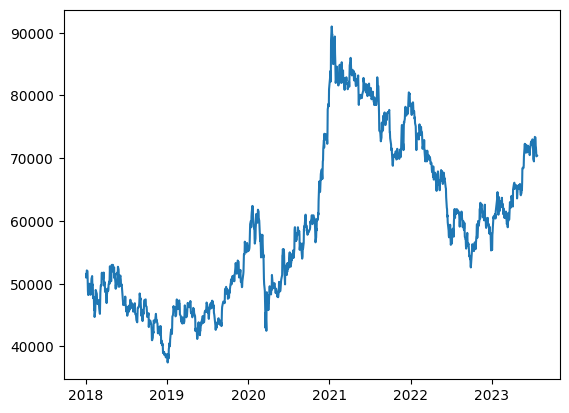

In [57]:
import matplotlib.pyplot as plt

plt.plot(df['Close'])
plt.show()

In [139]:
# 정규화 (StandardScaler)
# scaled_x = (df.Close - df.Close.mean()) / df.Close.std()

# 정규화 (MinMaxScaler) -> 값의 범위가 작을 때 이를 확장
min_value = df.Close.min()
max_value = df.Close.max()
scaled_x = (df.Close - min_value) / (max_value - min_value)

# 정규화 (Robust Scaler) -> 이상치 포함된 데이터
# from sklearn.preprocessing import RobustScaler
# scaled_x = RobustScaler().fit_transform((df.Close).to_numpy().reshape(-1, 1))

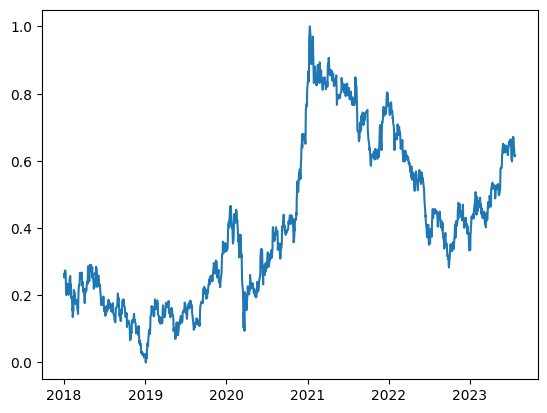

In [140]:
plt.plot(scaled_x)
plt.show()

### 데이터 전처리 - 5일치로 자르기

In [141]:
import numpy as np
X = np.array([
    [
        scaled_x[i+j] for j in range(5)     # 5일치 seq로 설정
        ] for i in range(len(scaled_x) - 5) # 데이터 범위 잡아주는 반복문 설정
    ])
y = np.array([
        scaled_x[i+5]   # i+5 day -> target date
        for i in range(len(scaled_x) - 5) # 범위
        ])

In [142]:
X.shape, y.shape

((1366, 5), (1366,))

### 학습 데이터 분리 (앞 80%, 뒤 20%)

In [143]:
train_idx = int(len(X) * 0.8)   # 80% 데이터까지의 인덱스

In [144]:
train_idx

1092

In [145]:
X_train = X[:train_idx]
y_train = y[:train_idx]
X_test = X[train_idx:]
y_test = y[train_idx:]

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1092, 5), (1092,), (274, 5), (274,))

### 데이터셋, 데이터로더 정의

In [146]:
from torch.utils.data import Dataset, DataLoader

class CustomDataset(Dataset):
    def __init__(self, x, y):
        self.x = torch.Tensor(x).reshape(-1, 5, 1)
        self.y = torch.Tensor(y)

    def __getitem__(self, index):
        return self.x[index], self.y[index]

    def __len__(self):
        return len(self.x)

train_dataset = CustomDataset(X_train, y_train)
test_dataset = CustomDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=36, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=36)

### 모델링

- GRU 활용

In [147]:
import torch.nn as nn

class SimpleGRU(nn.Module):
    def __init__(self):
        super(SimpleGRU, self).__init__()
        self.gru = nn.GRU(input_size=1, hidden_size=32, num_layers=3, dropout=0.2, batch_first=True)
        self.fc = nn.Sequential(
            nn.Linear(32, 1),
        )

    def forward(self, x):
        output, hidden = self.gru(x)
        output = self.fc(hidden[-1])
        return output

model = SimpleGRU()

### 컴파일

In [148]:
import torch
import torch.optim as optim

device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

criterion = nn.MSELoss()#.cuda() - gpu 설정     # 예측값과 실제값의 오차를 줄이기 위한 회귀 문제이므로 MSELoss 활용
optimizer = optim.Adam(model.parameters(), lr=0.5)

### 모델 학습

- 큰 반복문: epochs
- 작은 반복문: train_loader

- 학습 순서
    1. model output -> feed forward
    2. loss 계산 (real, output)
    3. back propagation (역전파)

In [149]:
from tqdm import tqdm

epochs = 5
for epoch in range(epochs):
    model.train()   # 모델 학습 모드로 변경
    train_loss = []

    for data, label in train_loader:
        data, label = data.to(device), label.to(device)
        optimizer.zero_grad()   # 기존의 계산된 기울기 값 초기화

        output = model(data)    # feed forward
        loss = criterion(output, label) # loss 계산

        loss.backward()     # back propagation
        optimizer.step()    # 가중치 update
        train_loss.append(loss.item())

    _train_loss = np.mean(train_loss)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([36])) that is different to the input size (torch.Size([36, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([12])) that is different to the input size (torch.Size([12, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


### 모델 검증 (예측)

In [152]:
y_pred = torch.Tensor([])
y_real = torch.Tensor([])

model.eval()
for data, label in test_loader:
    with torch.no_grad():
        output = model(data)    # feed forward

    y_pred = torch.cat([y_pred, output])
    y_real = torch.cat([y_real, label])

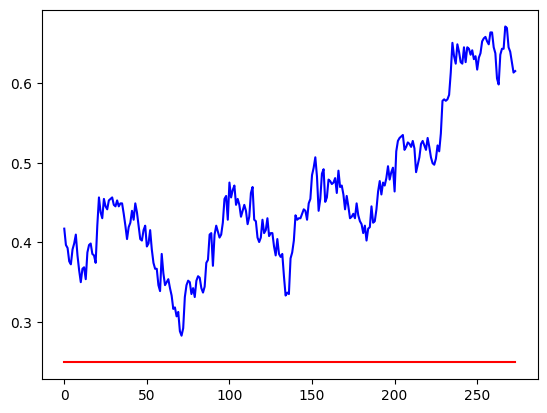

In [153]:
plt.plot(y_pred, color='red')
plt.plot(y_real, color='blue')
plt.show()

### XGBoost로 학습하기

In [154]:
import xgboost as xgb
model = xgb.XGBRegressor()

In [155]:
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)